In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from arch import arch_model
#import vartests

## This Notebook Aims to display how we calculate the VaR($\Delta$ BOF)

In [118]:
def fetch_data_df():
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    return df

In [119]:
returns_df = fetch_data_df()
returns_df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-11,0.003231,0.006833,0.004578,-0.001342,-0.001916,-0.004075,0.0193
2005-10-12,-0.003550,-0.009657,-0.007867,-0.002606,-0.001570,-0.004370,0.0208
2005-10-13,-0.018599,-0.010692,0.000588,-0.002331,-0.003062,-0.003423,0.0208
2005-10-14,-0.007856,0.001569,-0.002991,-0.000564,0.000060,0.001618,0.0208
2005-10-17,-0.003613,0.000492,0.003290,0.000458,-0.000227,0.005447,0.0208


In [120]:
returns_df.shape

(4680, 7)

In [121]:
returns_df.describe()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
count,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4666.000000
mean,0.000144,0.000379,0.000359,0.000141,0.000097,0.000231,0.009028
std,0.013330,0.013358,0.010088,0.002483,0.002950,0.003131,0.016355
min,-0.114930,-0.128207,-0.100676,-0.031052,-0.016023,-0.047106,-0.005930
25%,-0.006136,-0.005096,-0.003986,-0.001150,-0.001443,-0.000609,-0.003590
50%,0.000391,0.000982,0.000799,0.000246,0.000168,0.000428,0.001010
75%,0.006888,0.006793,0.005328,0.001577,0.001610,0.001284,0.023300
max,0.095947,0.127987,0.088746,0.016284,0.020704,0.028941,0.046010


## Creating Three different distributions for VaR($\Delta$ BoF)
Done by doing Monte Carlo Simulations
1. Assume normal distribution
2. Assume t-student
3. Use GARCH (fuck this)

**Paramters**

In [122]:
assets_0 = 100000
liabilities_0 = assets_0 * 0.6
liability_growth = 0.03

weights = np.array([0.1, 0.6, 0.05, 0.05, 0.05, 0.05, 0.1]) 

n_simulations = 100000
n_days = 252  # 1 year is typically 252 trading days

asset_classes = returns_df.columns

### Assuming normal

In [123]:
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Check the variance of EONIA
print("Variance of EONIA:", cov_matrix['EONIA']['EONIA'])


Variance of EONIA: 0.00026747127359195955


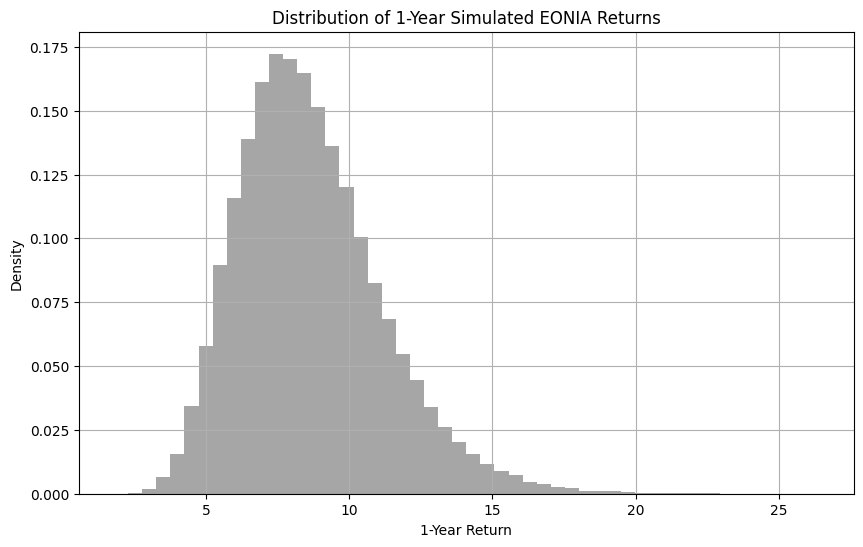

In [124]:
eonia_mean = mean_returns['EONIA']
eonia_std = np.sqrt(cov_matrix['EONIA']['EONIA'])

# Simulate daily returns for EONIA using a normal distribution
simulated_eonia_daily_returns = np.random.normal(eonia_mean, eonia_std, (n_simulations, n_days))

# Calculate cumulative returns for each simulation over 1 year
simulated_eonia_cumulative_returns = np.cumprod(1 + simulated_eonia_daily_returns, axis=1)[:, -1] - 1

# Plot the distribution of the simulated EONIA cumulative returns
plt.figure(figsize=(10, 6))
plt.hist(simulated_eonia_cumulative_returns, bins=50, alpha=0.7, color='gray', density=True)
plt.title('Distribution of 1-Year Simulated EONIA Returns')
plt.xlabel('1-Year Return')
plt.ylabel('Density')
plt.grid(True)
plt.show()

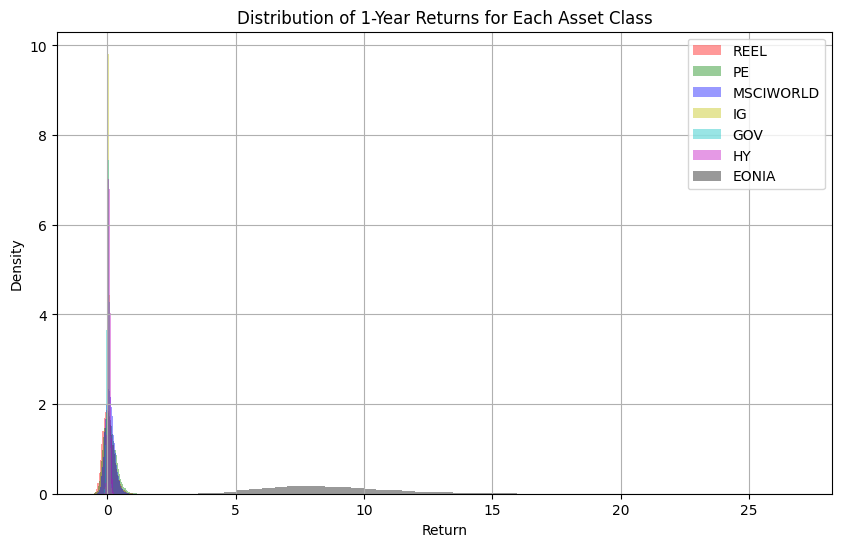

In [125]:
# Simulate daily returns for 1 year using the multivariate normal distribution
simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, (n_simulations, n_days))

# Calculate cumulative returns for each asset class over 1 year
simulated_cumulative_returns = np.cumprod(1 + simulated_daily_returns, axis=1)[:, -1] - 1

plt.figure(figsize=(10, 6))

colors = ['r', 'g', 'b', 'y', 'c', 'm', "k", "n"]  # Colors for each asset class (adjust to match the number of assets)

for i, asset_class in enumerate(asset_classes):
    plt.hist(simulated_cumulative_returns[:, i], bins=50, alpha=0.4, color=colors[i], label=asset_class, density=True)

plt.title('Distribution of 1-Year Returns for Each Asset Class')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


In [126]:
simulated_daily_returns.shape, simulated_cumulative_returns.shape

((100000, 252, 7), (100000, 7))

Now make same plot but for basic own funds

In [127]:
def plot_BOF_distribution(simulated_daily_returns):
    BOF_0 = assets_0 - liabilities_0  

    portfolio_returns = np.dot(simulated_daily_returns, weights) 
    simulated_cumulative_returns = np.cumprod(1 + portfolio_returns, axis=1)[:, -1] - 1

    assets_t1 = assets_0 * (1 + simulated_cumulative_returns)  # Assets after 1 year
    liabilities_t1 = liabilities_0 * (1 + liability_growth)  # Liabilities after 1 year

    bof_t1 = assets_t1 - liabilities_t1
    bof_change = bof_t1 - BOF_0

    scr = np.percentile(bof_change, 100 * (1 - 0.995))

    plt.figure(figsize=(10, 6))
    plt.hist(bof_change / 1e6, bins=500, alpha=0.7, color='c', label='Change in BOF Distribution', density=True)
    plt.axvline(np.percentile(bof_change, 0.5) / 1e6, color='r', linestyle='--', label='VaR (alpha=0.995)')
    plt.title('Distribution of Change in BOF after 1 Year: Monte Carlo')
    plt.xlabel('Change in BOF (Millions)')
    plt.ylabel('Density')
    
    plt.xlim(-2, 2)
    plt.xticks(np.arange(-2, 2.5, 0.5))  # Increments of 0.5 within the range [-2, 2]

    plt.legend()
    plt.grid(True)
    plt.show()

    return bof_change



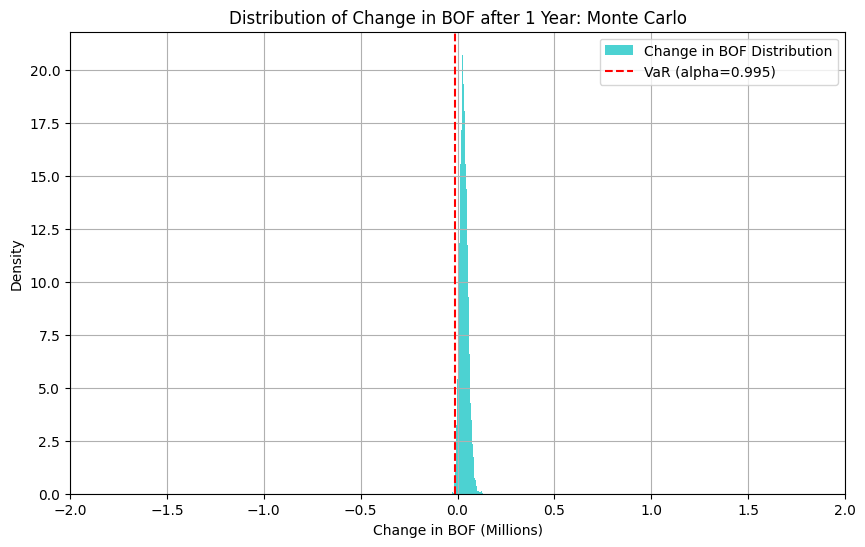

In [128]:
bof_normal = plot_BOF_distribution(simulated_daily_returns)

## Assuming t-student

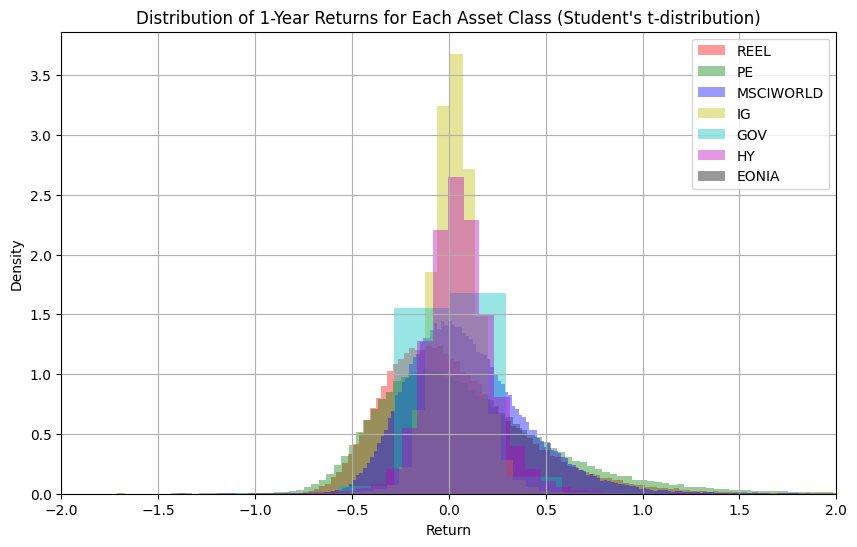

In [129]:
# Fit a t-distribution to each asset's daily returns to estimate degrees of freedom, mean, and scale
t_params = [t.fit(returns_df[col].dropna()) for col in returns_df.columns]
df_degrees = [params[0] for params in t_params]  # Extract degrees of freedom for each asset

# Initialize an array to store simulated daily returns for all assets
simulated_daily_returns = np.zeros((n_simulations, n_days, len(mean_returns)))

# Generate daily returns for each asset using the t-distribution
for i, (mean, std, df) in enumerate(zip(mean_returns, np.sqrt(np.diag(cov_matrix)), df_degrees)):
    simulated_daily_returns[:, :, i] = t.rvs(df, loc=mean, scale=std, size=(n_simulations, n_days))

# Calculate cumulative returns over 1 year for each simulation and asset
simulated_cumulative_returns = np.cumprod(1 + simulated_daily_returns, axis=1)[:, -1, :] - 1

# Plot the distribution of 1-year returns for each asset
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'y', 'c', 'm', "k"]  # Colors for each asset class

for i, asset_class in enumerate(returns_df.columns):
    plt.hist(
        simulated_cumulative_returns[:, i],
        bins=500,
        alpha=0.4,
        color=colors[i % len(colors)],
        label=asset_class,
        density=True
    )

plt.title('Distribution of 1-Year Returns for Each Asset Class (Student\'s t-distribution)')
plt.xlabel('Return')
plt.ylabel('Density')

# Adjust x-axis limits to broaden the view
plt.xlim(-2, 2)  # Adjust as necessary to provide a wider view

plt.grid(True)
plt.legend(loc='upper right')
plt.show()


In [130]:
simulated_daily_returns.shape, simulated_cumulative_returns.shape

((100000, 252, 7), (100000, 7))

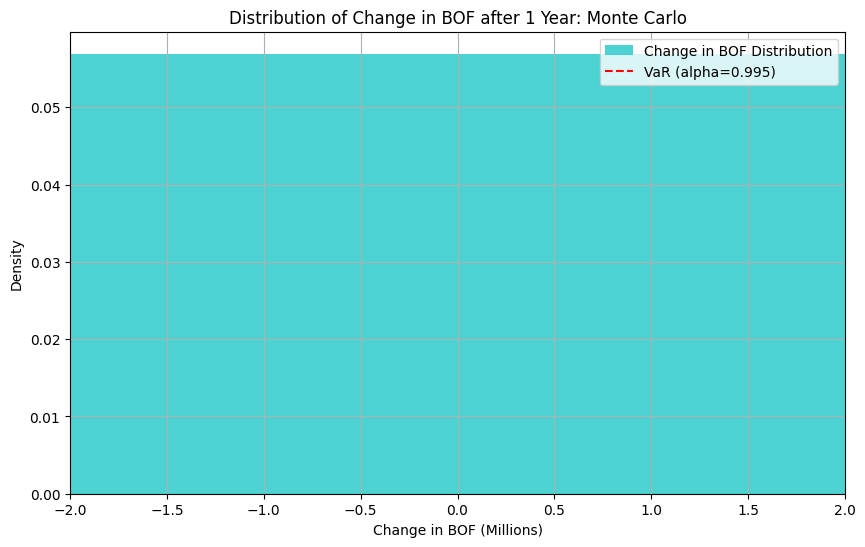

In [131]:
bof_t_student = plot_BOF_distribution(simulated_daily_returns)

## Testing our VaR distributions

- Christoffersen test

In [132]:
from VaRTests import christoffersen_test

In [133]:
confidence_level = 0.995

def perform_test(dist):
    var_threshold = np.percentile(dist, 100 * (1 - confidence_level))

    violations = (dist < var_threshold).astype(int)

    results = christoffersen_test(violations, confidence_level=confidence_level)

    print("Christoffersen Test Results:")
    for key, value in results.items():
        print(f"{key}: {value:.4f}")

In [134]:
perform_test(bof_t_student)

Christoffersen Test Results:
Unconditional Coverage Statistic: 1054370.1685
Unconditional Coverage p-value: 0.0000
Independence Statistic: 6295.0341
Independence p-value: 0.0000
Joint Test Statistic: 1060665.2026
Joint Test p-value: 0.0000


In [135]:
perform_test(bof_normal)

Christoffersen Test Results:
Unconditional Coverage Statistic: 1054370.1685
Unconditional Coverage p-value: 0.0000
Independence Statistic: 6295.7082
Independence p-value: 0.0000
Joint Test Statistic: 1060665.8767
Joint Test p-value: 0.0000


In [136]:
vartests.kupiec_test

NameError: name 'vartests' is not defined

## Using GARCH (fuck this)

In [ ]:
n_simulations = 1000

Testing out GARCH

In [ ]:
asset_returns_scaled = returns_df * 100

for asset in asset_returns_scaled.columns:
    asset_returns = asset_returns_scaled[asset].dropna()  # Replace with an actual column name

    # Step 1: Fit the GJR-GARCH(1,1) model
    gjr_garch_model = arch_model(asset_returns, vol='Garch', p=1, o=1, q=1, dist='t', rescale=False)
    model_fit = gjr_garch_model.fit(disp="off", options={'maxiter': 1000}) 

    # Display the model summary
    print(model_fit.summary())

                             Constant Mean - GJR-GARCH Model Results                             
Dep. Variable:     FTSE EPRA Nareit Developed Europe TRI   R-squared:                       0.000
Mean Model:                                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                     GJR-GARCH   Log-Likelihood:               -6963.61
Distribution:                   Standardized Student's t   AIC:                           13939.2
Method:                               Maximum Likelihood   BIC:                           13977.9
                                                           No. Observations:                 4682
Date:                                   Tue, Nov 12 2024   Df Residuals:                     4681
Time:                                           12:53:45   Df Model:                            1
                                 Mean Model                                 
                 coef    std err         

In [ ]:
asset_returns_scaled = returns_df * 100  # Scale the returns by 100 if needed

# Number of days to simulate
num_simulation_days = 252

# Number of simulation paths
num_simulations = 1000

# Confidence level for VaR
confidence_level = 0.95

# Step 1: Fit GJR-GARCH model to each asset
gjr_garch_models = {}
for asset in asset_returns_scaled.columns:
    asset_returns = asset_returns_scaled[asset].dropna()
    gjr_garch_model = arch_model(asset_returns, vol='Garch', p=1, o=1, q=1, dist='t', rescale=False)
    model_fit = gjr_garch_model.fit(disp="off", options={'maxiter': 1000})
    gjr_garch_models[asset] = model_fit
    print(f"GJR-GARCH model for {asset} fitted.")

# Step 2: Forecast future volatility and simulate returns
simulated_returns = np.zeros((num_simulation_days, num_simulations, len(asset_returns_scaled.columns)))

for idx, (asset, model_fit) in enumerate(gjr_garch_models.items()):
    # Forecast volatility using the GJR-GARCH model
    forecasts = model_fit.forecast(horizon=num_simulation_days)
    forecasted_volatility = np.sqrt(forecasts.variance.values[-1, :])
    
    # Simulate returns based on the forecasted volatility
    for t in range(num_simulation_days):
        # Generate random returns using the t-distribution scaled by the forecasted volatility
        simulated_returns[t, :, idx] = forecasted_volatility[t] * np.random.standard_t(df=model_fit.params['nu'], size=num_simulations)

# Step 3: Calculate portfolio returns using the weights
simulated_portfolio_returns = np.einsum('tij,j->ti', simulated_returns, weights)

# Step 4: Calculate VaR at the given confidence level
var_value = np.percentile(simulated_portfolio_returns, (1 - confidence_level) * 100, axis=1)
print(f"Value at Risk (VaR) at {confidence_level * 100}% confidence level over {num_simulation_days} days: {var_value[-1]:.2f}%")

GJR-GARCH model for FTSE EPRA Nareit Developed Europe TRI fitted.
GJR-GARCH model for LPX50PE fitted.
GJR-GARCH model for MSCI World fitted.
GJR-GARCH model for ICE BofA G0BC (Corporate World) fitted.
GJR-GARCH model for FTSE EMU Government Bond (EGBI) TRI fitted.
GJR-GARCH model for ICE BofA HW00 (Global HY) fitted.
Value at Risk (VaR) at 95.0% confidence level over 252 days: -1.64%
